# Quick note : Code was wrtitten and run in Google Colab

# Import the datasets from Kaggle

In [ ]:
! pip install kaggle # Install the Kaggle library
! mkdir ~/.kaggle    # Make a directory named “.kaggle”
! cp kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory
! chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file.
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

# Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import cv2

import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
import pickle

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# TensorBoard
from keras.callbacks import TensorBoard
import time

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Preprocessing of Datasets

In [20]:
# Generate Normal, Pneumonia data

img_size = 150
labels = ["NORMAL", "PNEUMONIA"]

def create_training_data(wd):
  traininig_data = []
  for label in labels:
    path = os.path.join(wd, label)
    class_num = labels.index(label)
    for img in os.listdir(path):

      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (img_size,img_size))
        traininig_data.append([new_array, class_num])
      except:
          print("error file = ", path)
          
  return np.array(traininig_data, dtype=object)


In [13]:
# Normal vs. Pneumonia
train = create_training_data(os.getcwd()+'/chest_xray/train')
val = create_training_data(os.getcwd()+'/chest_xray/val')
test = create_training_data(os.getcwd()+'/chest_xray/test')

In [ ]:
print(len(train), len(val), len(test))

5216 16 624


1
0
1


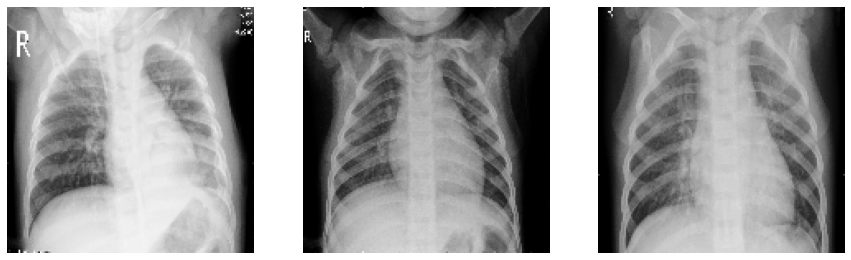

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
ax[0].imshow(train[5000][0], cmap='gray')
print(train[5000][1])

ax[1].imshow(val[5][0], cmap='gray')
print(val[5][1])

ax[2].imshow(test[600][0], cmap='gray')
print(test[600][1])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off');

In [ ]:
# Random_suffle : return None
np.random.shuffle(train)
np.random.shuffle(val)
np.random.shuffle(test)

1
1
0


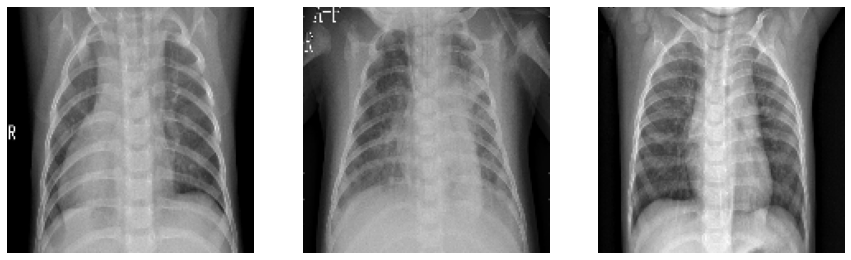

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
ax[0].imshow(train[5000][0], cmap='gray')
print(train[5000][1])

ax[1].imshow(val[5][0], cmap='gray')
print(val[5][1])

ax[2].imshow(test[600][0], cmap='gray')
print(test[600][1])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off');

In [15]:
X_train = []
y_train = []

for features, label in train:
  X_train.append(features)
  y_train.append(label)

X_val = []
y_val = []

for features, label in val:
  X_val.append(features)
  y_val.append(label)

X_test = []
y_test = []

for features, label in test:
  X_test.append(features)
  y_test.append(label)

# Convert to numpy array & Separate feature and label
#.reshape(-1,img_size, img_size, 1) --> 1 for gray_scale, 3 for colors (row, width, height, layer(color channel))

X_train = np.array(X_train).reshape(-1,img_size, img_size, 1) 
y_train = np.array(y_train)

X_val = np.array(X_val).reshape(-1,img_size, img_size, 1) 
y_val = np.array(y_val)

X_test = np.array(X_test).reshape(-1,img_size, img_size, 1) 
y_test = np.array(y_test)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((5216, 150, 150, 1), (16, 150, 150, 1), (624, 150, 150, 1))

In [16]:
# Data Scaling -  Normalization
X_train_norm = X_train / 255
X_val_norm = X_val / 255
X_test_norm = X_test / 255

In [ ]:
X_train_norm.shape, X_val_norm.shape, X_test_norm.shape

((5216, 150, 150, 1), (16, 150, 150, 1), (624, 150, 150, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((5216,), (16,), (624,))

In [ ]:
np.unique(y_train), np.unique(y_val), np.unique(y_test)

(array([0, 1]), array([0, 1]), array([0, 1]))

In [ ]:
# Convert label to categorical data
y_train_oh = to_categorical(y_train, num_classes=2)
y_val_oh = to_categorical(y_val, num_classes=2)
y_test_oh = to_categorical(y_test, num_classes=2)

In [ ]:
y_train_oh.shape, y_val_oh.shape, y_test_oh.shape

((5216, 2), (16, 2), (624, 2))

## EDA / Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       5216 non-null   int64
dtypes: int64(1)
memory usage: 40.9 KB
None

0    1341
1    3875
dtype: int64



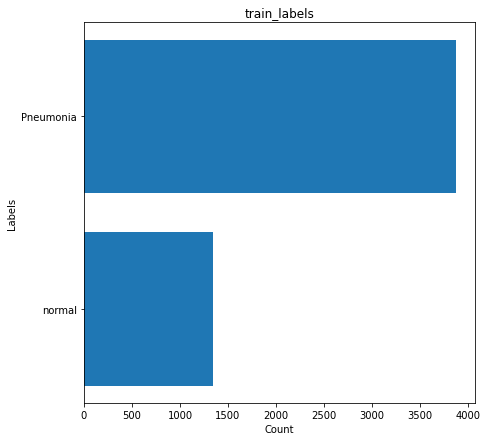

In [ ]:
train_labels = pd.DataFrame(y_train)
print(train_labels.info())
print()
print(train_labels.value_counts().sort_index())
print()
plt.figure(figsize=(7,7))
plt.barh(['normal',"Pneumonia"], 
         train_labels.value_counts().sort_index().values)
plt.title("train_labels")
plt.xlabel('Count')
plt.ylabel('Labels');

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       624 non-null    int64
dtypes: int64(1)
memory usage: 5.0 KB
None

0    234
1    390
dtype: int64



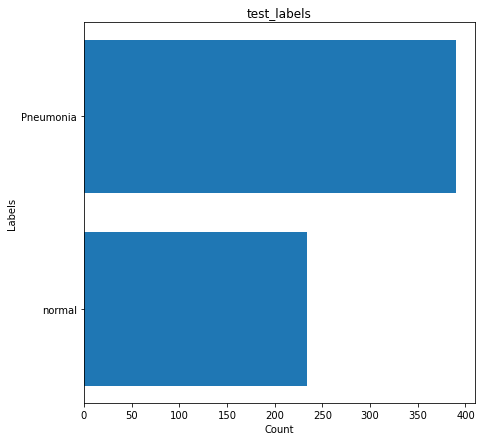

In [ ]:
test_labels = pd.DataFrame(y_test)
print(test_labels.info())
print()
print(test_labels.value_counts().sort_index())
print()
plt.figure(figsize=(7,7))
plt.barh(['normal',"Pneumonia"], 
         test_labels.value_counts().sort_index().values)
plt.title("test_labels")
plt.xlabel('Count')
plt.ylabel('Labels');

In [ ]:
# Viral infection is diffusive -> more brighter regions in the pics; therefore, higher avg. pixel values?
# Bacterial infection 

normal_val = []
pneumonia_val = []

for num in range(len(train)):
  if train[num][1] == 0:
    normal_val.append(np.average(train[num][0]))
  elif train[num][1] == 1:
    pneumonia_val.append(np.average(train[num][0]))

print(sum(normal_val) / len(normal_val))
print(sum(pneumonia_val) / len(pneumonia_val))

122.27166668323811
123.08860530465955


In [ ]:
normal_val = []
pneumonia_val = []

for num in range(len(test)):
  if test[num][1] == 0:
    normal_val.append(np.average(test[num][0]))
  elif test[num][1] == 1:
    pneumonia_val.append(np.average(test[num][0]))

print(sum(normal_val) / len(normal_val))
print(sum(pneumonia_val) / len(pneumonia_val))

123.98418860398857
119.10896353276367


# Balancing the imbalanced datasets
  * Data Augmentation
  * Oversampling


## Data Augumentation
    * Check "X_Ray_Normal_Pneumonia_Augmented.ipynb" for a model using data augmentation.

# Save Preprocessed Datasets 

In [ ]:
# pickle to save data! so that dont have to preprocess again
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
# import preprocessed datasets
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)
X_norm = X / 255

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

# Modeling

In [ ]:
# dense_layers =[0,1,2] # number of dense layers to add
# layer_sizes = [32,64,128] # Bath_size
# conv_layers = [1,2,3]

dense_layers = [2] 
layer_sizes = [128]
conv_layers = [1]

for dense_layer in dense_layers:
  for layer_size in layer_sizes:
    for conv_layer in conv_layers:
      NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
      tensorboard = TensorBoard(log_dir="logs/{}".format(NAME)) # set directory to save the result

      # Create a model
      model = Sequential()

      # Convolutional Layers
      model.add(Conv2D(layer_size, (3, 3), input_shape=X_train_norm.shape[1:], activation = 'relu')) # (3,3) : size of windows(for conv)
      #model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2,2)))

      for _ in range(conv_layer-1):
        model.add(Conv2D(layer_size, (3, 3), activation='relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
      
      # Flatten Layer
      model.add(Flatten())  # Flatten before dense layer!
      
      # Dense Layers
      for _ in range(dense_layer):
        model.add(Dense(layer_size, activation='relu'))

      # Output Layer
      model.add(Dense(2, activation='softmax'))

      model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])
      
      early_stopping_cb = EarlyStopping(patience=3, monitor='val_loss')

      model.fit(X_train_norm, y_train,
          batch_size=32,
          epochs=10,
          validation_split=0.2,
          callbacks=[tensorboard, early_stopping_cb],
          verbose = 1)
      

Epoch 1/4
131/131 [==============================] - 31s 140ms/step - loss: 0.7944 - accuracy: 0.8648 - val_loss: 0.0850 - val_accuracy: 0.9684
Epoch 2/4
131/131 [==============================] - 18s 135ms/step - loss: 0.0734 - accuracy: 0.9703 - val_loss: 0.0657 - val_accuracy: 0.9770
Epoch 3/4
131/131 [==============================] - 18s 136ms/step - loss: 0.0365 - accuracy: 0.9863 - val_loss: 0.0830 - val_accuracy: 0.9741
Epoch 4/4
131/131 [==============================] - 18s 136ms/step - loss: 0.0218 - accuracy: 0.9938 - val_loss: 0.0590 - val_accuracy: 0.9789


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 700928)            0         
                                                                 
 dense (Dense)               (None, 128)               89718912  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                        

In [ ]:
# Start TensorBoard
%tensorboard --logdir logs

In [ ]:
# Save the Best Model
model.save('1x128x2_CNN_NP.h5') 

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('1x128x2_CNN_NP.h5')

# Model Evaluations

In [ ]:
model.evaluate(X_train_norm, y_train)

163/163 [==============================] - 7s 39ms/step - loss: 0.0164 - accuracy: 0.9956


[0.01639649271965027, 0.9955905079841614]

In [ ]:
predictions = model.predict(X_train_norm)

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_train, np.argmax(predictions, axis=1))
pd.DataFrame(cm, index = ['Normal','Pneumonia'] , columns = ['Normal','Pneumonia'])

,Normal,Pneumonia
Normal,1328,13
Pneumonia,10,3865


### Plot 1

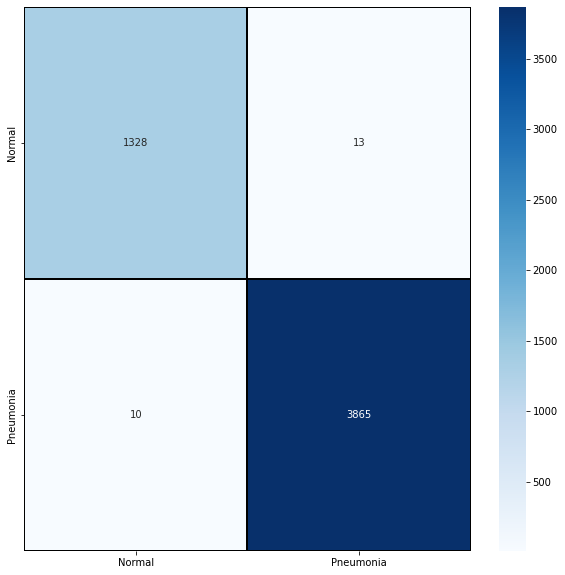

In [ ]:
plt.figure(figsize = (10,10))

sns.heatmap(cm, cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True, 
            fmt='',
            xticklabels = ['Normal','Pneumonia'],
            yticklabels = ['Normal','Pneumonia']);

### Plot 2

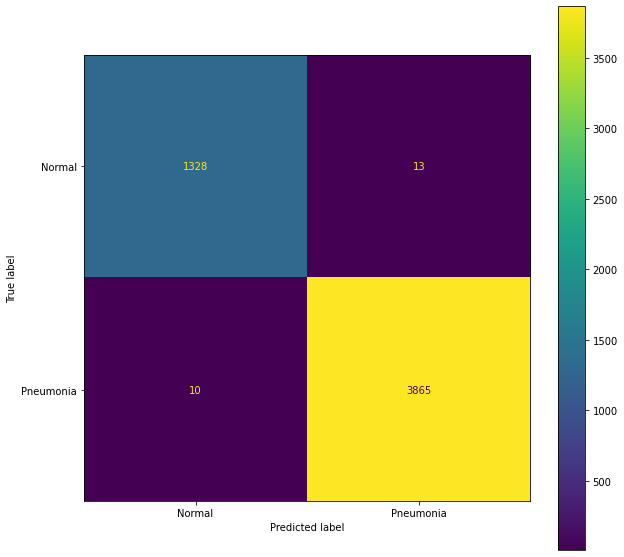

In [ ]:
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['Normal','Pneumonia'])
fig, ax = plt.subplots(figsize=(10,10))
cm_plot.plot(ax=ax);

## Classification Report
    * precision = tp / (tp + fp)
    * recall (sensitivity) = tp / (tp + fn)

In [ ]:
print(classification_report(y_train, 
                            np.argmax(predictions, axis=1), 
                            target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      1341
   Pneumonia       1.00      1.00      1.00      3875

    accuracy                           1.00      5216
   macro avg       0.99      0.99      0.99      5216
weighted avg       1.00      1.00      1.00      5216



## Accuracy Score

In [ ]:
accuracy_score(y_train, np.argmax(predictions, axis=1))

0.995590490797546

## Test_set 

In [ ]:
model.evaluate(X_test_norm,y_test)

20/20 [==============================] - 1s 49ms/step - loss: 1.6031 - accuracy: 0.7244


[1.6030958890914917, 0.7243589758872986]

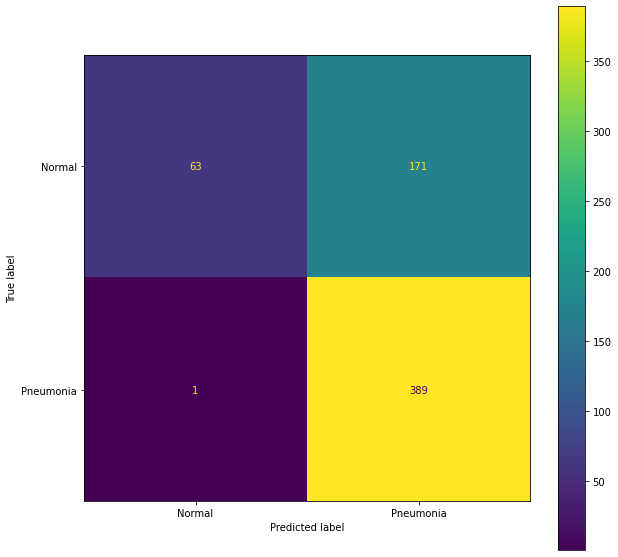

In [ ]:
predictions_test = model.predict(X_test_norm)
cm_test = confusion_matrix(y_test, np.argmax(predictions_test, axis=1))
cm_plot_test = ConfusionMatrixDisplay(cm_test, display_labels=['Normal','Pneumonia'])
fig, ax = plt.subplots(figsize=(10,10))
cm_plot_test.plot(ax=ax);

In [ ]:
print(classification_report(y_test, 
                            np.argmax(predictions_test, axis=1), 
                            target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.98      0.27      0.42       234
   Pneumonia       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.63      0.62       624
weighted avg       0.80      0.72      0.67       624



## Augmented_model

In [21]:
test = create_training_data(os.getcwd()+'/chest_xray/test')

X_test = []
y_test = []

for features, label in test:
  X_test.append(features)
  y_test.append(label)

X_test = np.array(X_test).reshape(-1,img_size, img_size, 1) 
y_test = np.array(y_test)
X_test_norm = X_test / 255

In [22]:
X_test.shape, y_test.shape

((624, 150, 150, 1), (624,))

In [7]:
model_aug = tf.keras.models.load_model('aug_model.h5')

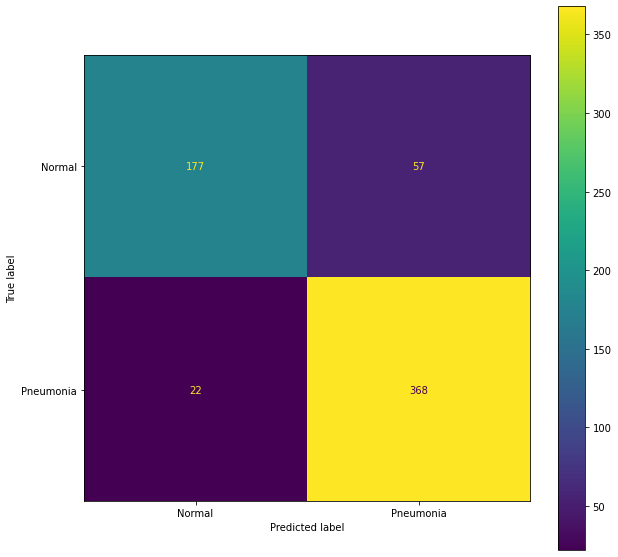

In [23]:
predictions_test = model_aug.predict(X_test_norm)
cm_test = confusion_matrix(y_test, np.argmax(predictions_test, axis=1))
cm_plot_test = ConfusionMatrixDisplay(cm_test, display_labels=['Normal','Pneumonia'])
fig, ax = plt.subplots(figsize=(10,10))
cm_plot_test.plot(ax=ax);

In [24]:
print(classification_report(y_test, 
                            np.argmax(predictions_test, axis=1), 
                            target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.89      0.76      0.82       234
   Pneumonia       0.87      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624



In [25]:
model_aug.evaluate(X_test_norm, y_test)

20/20 [==============================] - 1s 44ms/step - loss: 0.4072 - accuracy: 0.8734


[0.40717631578445435, 0.8733974099159241]